<a href="https://colab.research.google.com/github/ruus77/data_analysis/blob/main/SMA_Stratrgy_for_InPost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import pandas as pd
import numpy as np
try:
  import yfinance as yf
except:
  !pip install yfinance
  import yfinance as yf
from pylab import mpl, plt

plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'serif'

In [129]:
TICKER = "INPST.AS"
data = yf.download(
    tickers=TICKER,
    period="max",
    interval="1d",
    ignore_tz=True,
    auto_adjust=True,
)

[*********************100%***********************]  1 of 1 completed


In [130]:
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1189 entries, 2021-01-27 to 2025-09-15
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, INPST.AS)   1189 non-null   float64
 1   (High, INPST.AS)    1189 non-null   float64
 2   (Low, INPST.AS)     1189 non-null   float64
 3   (Open, INPST.AS)    1189 non-null   float64
 4   (Volume, INPST.AS)  1189 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 55.7 KB


In [131]:
df = data["Close"].copy()
df.columns=["close"]
df.index = pd.to_datetime(df.index)
df.head()

,close
Date,
2021-01-27,18.416000
2021-01-28,19.750000
2021-01-29,19.799999
2021-02-01,20.600000
2021-02-02,20.959999


In [132]:
df.describe()

,close
count,1189.000000
mean,12.103044
std,4.139620
min,4.182000
25%,8.524000
50%,12.930000
75%,15.754000
max,20.959999


<Axes: xlabel='Date'>

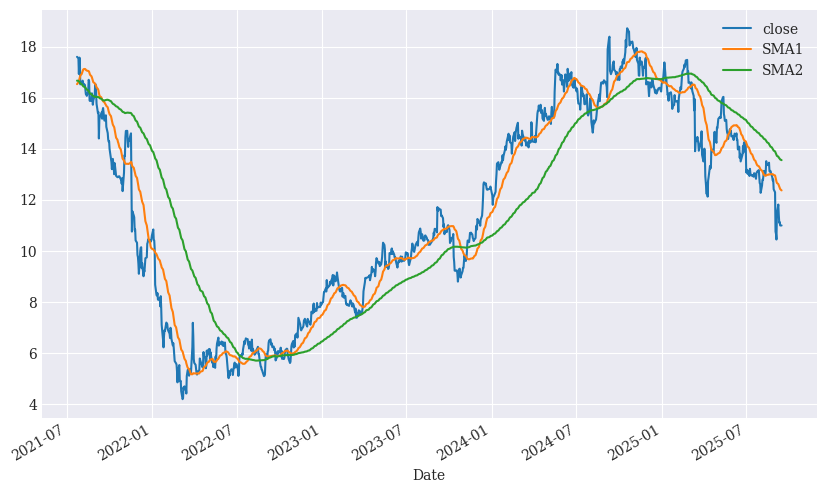

In [133]:
SMA1 = 30
SMA2 = int(252 / 2)
df["SMA1"] = df.close.rolling(SMA1).mean()
df["SMA2"] = df.close.rolling(SMA2).mean()
df.dropna(inplace=True)
df.plot(figsize=(10, 6))

In [134]:
df =df["20220201":].copy()
df["position"] = np.where(df.SMA1 > df.SMA2, 1, -1)
df["returns"] = np.log(df.close / df.close.shift(1))
df["strategy"] = df.returns * df.position.shift(1)
df = df.round(4)
df["20221124":"20221201"]

,close,SMA1,SMA2,position,returns,strategy
Date,,,,,,
2022-11-24,7.288,6.5262,6.0360,1,0.0025,0.0025
2022-11-25,7.332,6.5673,6.0433,1,0.0060,0.0060
2022-11-28,7.114,6.5991,6.0500,1,-0.0302,-0.0302
2022-11-29,7.062,6.6294,6.0552,1,-0.0073,-0.0073
2022-11-30,7.028,6.6671,6.0628,1,-0.0048,-0.0048
2022-12-01,7.328,6.7158,6.0737,1,0.0418,0.0418


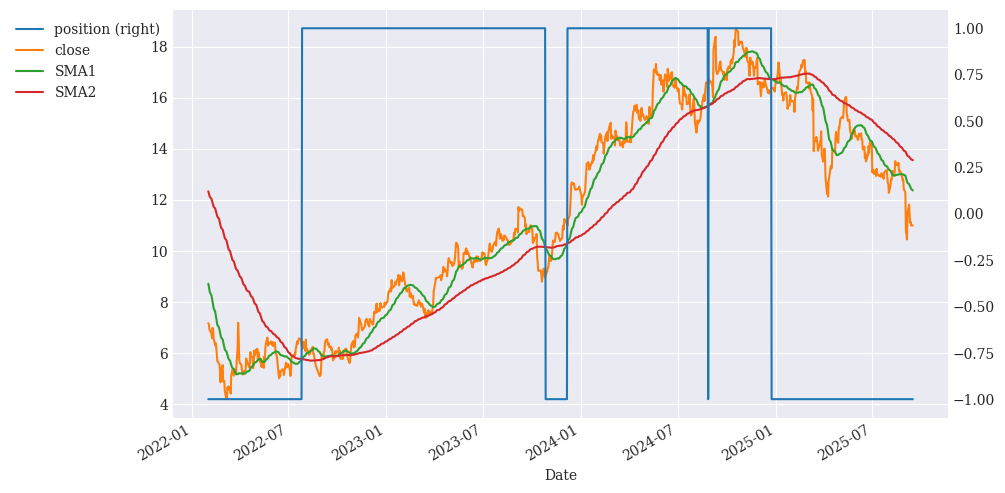

In [135]:
ax = df[["position", "close", "SMA1", "SMA2"]].plot(
              secondary_y='position',
              kind="line",
              figsize=(10, 6));
ax.get_legend().set_bbox_to_anchor((0, 1))

In [136]:
df.dropna(inplace=True)
df.shape

(926, 6)

In [137]:
np.exp(df[["returns", "strategy"]].sum())

,0
returns,1.534800
strategy,2.963586


In [138]:
num_of_trading_days = 252
(df[["returns", "strategy"]]).std()*num_of_trading_days**0.5

,0
returns,0.441522
strategy,0.441190


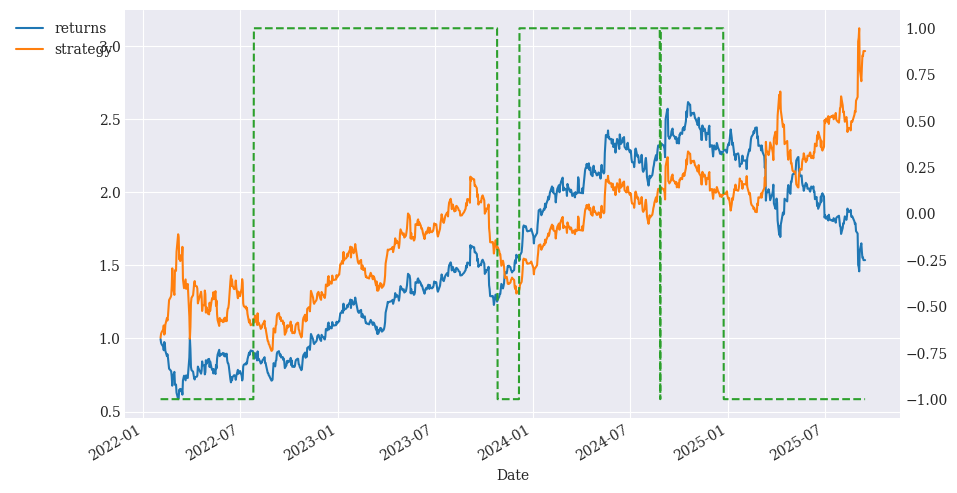

In [139]:
ax = df[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

df['position'].plot(ax=ax, secondary_y=True, style='--')

ax.get_legend().set_bbox_to_anchor((0, 1))

In [140]:
np.exp(df[["returns", "strategy"]].sum())

,0
returns,1.534800
strategy,2.963586


In [141]:
from itertools import product

In [161]:
sma1 = range(20, 61, 4)
sma2 = range(120,221 , 10)
l = []
for i in sma2:
  l.append(i)
len(l)

11

In [171]:
results_list = []

sma1_range = range(20, 61, 4)
sma2_range = range(120, 221, 10)

df_base = data["Close"].copy()
df_base.columns = ["close"]
df_base["returns"] = np.log(df_base.close / df_base.close.shift(1))


for SMA1, SMA2 in product(sma1_range, sma2_range):
    df = df_base.copy()

    df["SMA1"] = df.close.rolling(SMA1).mean()
    df["SMA2"] = df.close.rolling(SMA2).mean()

    df["position"] = np.where(df.SMA1 > df.SMA2, 1, -1)
    df["strategy"] = df.position.shift(1) * df.returns

    df.dropna(inplace=True)

    if not df.empty:
        perf = np.exp(df[["returns", "strategy"]].sum())

        results_list.append({
            'SMA1': SMA1,
            'SMA2': SMA2,
            'MARKET': perf['returns'],
            'STRATEGY': perf['strategy'],
            'OUT': perf['strategy'] - perf['returns']
        })

results = pd.DataFrame(results_list)

results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [172]:
results.sort_values(by="OUT", ascending=False)

,SMA1,SMA2,MARKET,STRATEGY,OUT
49,36,170,0.720561,10.732283,10.011721
30,28,200,0.801254,9.757493,8.956239
96,52,200,0.801254,9.743950,8.942696
74,44,200,0.801254,9.635471,8.834217
60,40,170,0.720561,9.305486,8.584925
...,...,...,...,...,...
1,20,130,0.625498,3.266799,2.641301
4,20,160,0.763194,3.148436,2.385241
0,20,120,0.617902,2.735654,2.117752
21,24,220,1.127758,3.216354,2.088596
